In [1]:
import warnings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>") )
warnings.filterwarnings("ignore")
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.display.float_format = "{:,.3f}".format
import glob
import os
import itertools as it
import pickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import time
import seaborn as sns
from scipy import stats
from sklearn import calibration


from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import matplotlib.ticker as plticker
import matplotlib.dates as mdates
import datetime as dt

from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import functools
import operator

def load_predictions_gen(_path_pred):
    
    if os.path.isdir(_path_pred):
        li_pred_fns = list( glob.glob(_path_pred+"/*", recursive=True) )
        li_pred_fns = [pred_fns for pred_fns in li_pred_fns if pred_fns[-4:]==".dat" ]
                
    elif os.path.isfile(_path_pred):
        li_pred_fns = [ _path_pred ]
                
    else:
        raise ValueError("Invalid File passed")
            
    li_pred_fns.sort()
    
    for pred_fn in li_pred_fns:
        pred = pickle.load(open(pred_fn,"rb"))
        yield pred
        
dict_prediction_path = {}

# Model Evaluation Code

In [64]:
def model_evaluation(datformation, rain_threshold=0.5, rolling_annual=False):
    
    prediction_path, distr_name, mname = init_helper(datformation)
    
    #timestamps, truevalues, preds = get_data(prediction_path)
#     li_pred_path = list( glob.glob(prediction_path+"/**",recursive=True) )
        
#     li_pred_path = [pred_path for pred_path in li_pred_path if pred_path[-4:]==".dat" ]
    
#     li_pred_path.sort()
    
    li_ts_tv_ps = get_data(prediction_path, multiple_files=False)
    
        
    timestamps, truevalues, preds =  li_ts_tv_ps

    fd = prediction_path.rsplit('/',2)[0]

    if os.path.isdir(prediction_path):
        _dir = prediction_path
    else:
        _dir = os.path.dirname(prediction_path)
    
    _dir_eval = os.path.join(_dir,"Evaluation")
    os.makedirs(_dir_eval,exist_ok=True)

    preds_mean = np.mean(preds,axis=-1)

    rmse = rmse_aggregate(preds_mean, truevalues)
    mae = avg_abs_bias(preds_mean, truevalues)
    rN_rmse, N = rN_aggregate(preds_mean, truevalues)

    dict_data = {'RMSE':[rmse], "R{}_RMSE".format(str(N)):[rN_rmse], 'MAE':[mae] }
    _dataframe = pd.DataFrame(dict_data )

    _dataframe.to_csv( os.path.join(_dir_eval, "general_scores.csv") ,index=False)

    #image_all_preds(timestamps, truevalues, preds_mean, _dir) #RODO: Convert images to make an image every say 90 days

    # Collecting an annually aggreagted set of results
    if rolling_annual==True:
        _dir_fe = os.path.join(fd,"Forecast_Evaluation")
        os.makedirs(_dir_fe, exist_ok=True)
        
        #Performing test on annual chunks and save results into one txt file

        _dataframe_1yre = year_rolling_eval( preds_mean, truevalues, timestamps, rain_threshold, distr_name, fd )

        #Save to csv file
        _dataframe_1yre.to_csv( os.path.join(_dir_fe,"annual_score.csv") ,index=False)
        
        stat_scores = ['RMSE','R10_RMSE','MAE']
        
        x = _dataframe_1yre['Start_Year']
        for stat_score in stat_scores:
            
            Y = _dataframe_1yre[stat_score]
                       
            fig, ax1 = plt.subplots( )

            ax1.set_xlabel('Year')
            ax1.set_ylabel(stat_score)
            ax1.plot(x,Y, marker='x' )
            ax1.grid(True)
            fig.tight_layout()  # otherwise the right y-label is slightly clipped
            fig.show()

            plt.savefig(os.path.join(_dir_fe,f"{stat_score}.png" ) )

    #print("Completed {} \n".format(fn) )

    return dict_data
            
def init_helper(datformation):
    
    if isinstance(datformation, dict):
        prediction_path = datformation['fp']
        distr_name = datformation['distr_name']
        model_name = datformation.get('model_name','')
    else:
        prediction_path = datformation
        distr_name =None
        
    return prediction_path, distr_name, model_name
    
def get_data(prediction_path, multiple_files=False):
    #return timestamps, truevalues, preds
    
    li_data = list(load_predictions_gen(prediction_path))
    li_ts_tv_ps = []
    
    for data in li_data:
        
        if 1 in data[1][0].shape and type(data[1][0]) != np.float64:    
            preds = np.concatenate(data[1][0])
            preds = np.reshape(data[1],[-1])
            preds = np.expand_dims(preds, [-1])
            
        
        elif type(data[1][0]) != np.float64 and type(data[1])==list:
            preds = np.concatenate( data[1],axis=0) 
            truevalues = np.concatenate( data[2],axis=0)
            timestamps = np.concatenate(data[0])
            
            
        elif len(data[1].shape) == len(data[2].shape):
            preds = np.expand_dims(data[1],axis=-1)
            truevalues = data[2]
            timestamps = data[0]
            
        else:
            
            preds = np.expand_dims(data[1],axis=1)
            truevalues = data[2]
            timestamps = data[0]
        
        li_ts_tv_ps.append( (timestamps, truevalues, preds) )
        
    if multiple_files == False:
        return li_ts_tv_ps[0]
    else:
        return li_ts_tv_ps
        
def percentile_cal(confidence, preds, distr_name):
    mean, sigma = np.mean(preds,axis=1), np.std(preds,ddof=1,axis=1)
#     print(mean)
#     print(sigma)

    if distr_name == "Normal":
        lp,up =  stats.norm.interval( confidence, loc=mean, scale=sigma)
        lp = np.where(lp>=0,lp, 0.0)

    elif distr_name == "LogNormal":
        ln_lp,ln_up = stats.lognorm.interval( confidence, scale=mean, s=underlying_normal_std_from_lnnormal_std(mean,sigma))
        ln_lp = np.where(ln_lp>=0,ln_lp, 0.0)
        
        n_lp,n_up =  stats.norm.interval( confidence, loc=mean, scale=sigma)
        n_lp = np.where(n_lp>=0,n_lp, 0.0)
        
        
        lp = np.where( mean>0.5,  ln_lp, n_lp )
        up = np.where( mean>0.5 , ln_up, n_up)
        
    else:
        raise ValueError
    
    return lp, up

def underlying_normal_std_from_lnnormal_std(ln_mean, ln_std):
    _1 = np.log( np.square(ln_std) + np.square(ln_mean) )
    _2 = -2 * np.log(ln_mean)
    sigma_norm = np.sqrt(_1 + _2)
    return sigma_norm
       
def rmse_aggregate(preds_mean,true_vals):
    return np.sqrt(np.nanmean((preds_mean-true_vals)**2))

def bias_aggregate(preds_mean, true_vals):
    return np.nanmean( preds_mean-true_vals )

def rN_aggregate(preds_mean, true_vals, N=10):
    
    mask = true_vals >= N
    
    preds_filt = preds_mean[mask]
    true_vals_filtr = true_vals[mask]
    
    return np.sqrt(np.nanmean((preds_filt-true_vals_filtr)**2)), N   

def avg_abs_bias(preds_mean, true_vals):
    diff = preds_mean-true_vals
    abs_diff = np.abs(diff)
    avg_abs_bias = np.nanmean(abs_diff)
    return avg_abs_bias
      
def image_all_preds(tss, true_val, pred_mean, prediction_path, fd, fn, save=True ):
    
    tss_string = [ time.strftime("%d-%m-%y", time.localtime(int(_val))) for _val in tss]
    
    start = pd.to_datetime( tss_string[0] )
    end = pd.to_datetime( tss_string[-1] ) + pd.Timedelta(1, 'd')
    
    ts = mdates.drange(start,end,dt.timedelta(days=1))
    
    fig, (ax) = plt.subplots(1)
    clrs = ['blue']# sns.color_palette("husl", 1)
    
    #with sns.axes_style("darkgrid"):        
    ax.plot(ts[:len(true_val)], true_val, c='black',linewidth=0.8)
    ax.plot(ts[:len(true_val)], pred_mean, c=clrs[0],linewidth=0.7)
        #ax.legend()
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=20) )
    
    ax.grid(True)
    
    fig.show()
    
    if save==True:
        img_dir = os.path.join(fd,"Images")
        fn_name = "preds_"+tss_string[0]+".png"
        if not os.path.exists(img_dir):
            os.makedirs(img_dir)

        plt.savefig(os.path.join(img_dir,fn_name ) )
        
def image_all_preds_compare(li_tss, li_true_vals, li_preds, li_confidence=[None,None], li_distr=[None,None], names=['Model1','Model2'], figsize=(10,6)):
    ts_strings = [ time.strftime("%d-%m-%y", time.localtime(int(_val))) for _val in li_tss[0] ]
    ts1_strings = [ time.strftime("%d-%m-%y", time.localtime(int(_val))) for _val in li_tss[1] ]
    
    try:
        start = pd.to_datetime( ts_strings[0] )
        end = pd.to_datetime( ts_strings[-1] ) + pd.Timedelta(1, 'd')

        start1 = pd.to_datetime( ts1_strings[0] )
        end1 = pd.to_datetime( ts1_strings[-1] ) + pd.Timedelta(1, 'd')
    
        ts = mdates.drange(start,end,dt.timedelta(days=1))
        ts1 = mdates.drange(start1,end1,dt.timedelta(days=1))
    except (ValueError,IndexError) as e:
        return
    
    li_ts = [ts,ts1]
    size=18
    fig, (ax) = plt.subplots(1,figsize=figsize)   
    #clrs = sns.color_palette("husl", 2)
    clrs = [ 'darkblue','darkorange' ]
    with sns.axes_style("whitegrid"):
    
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
        
        ax.xaxis.set_major_locator(mdates.AutoDateLocator() )
        #ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO) )
        
        if names[0] == names[1]:
            _range = 1
        else:
            _range = 2
        for idx in range(_range):
            _mean = np.mean(li_preds[idx],-1)
            
            _len = min( len(li_true_vals[idx]), len(li_ts[idx])  )

            if idx == 0:
                ax.plot(li_ts[idx][:_len], li_true_vals[idx][:_len], c='grey',linewidth=6, label="True Rain", alpha=0.5)
            
            ax.plot(li_ts[idx][:_len], _mean[:_len], c=clrs[idx], label=names[idx], linestyle=':' , linewidth=4.0)

            if li_distr[idx] != None:
                lq, uq = percentile_cal(li_confidence[idx], li_preds[idx], li_distr[idx] )
                ax.fill_between(li_ts[idx][:_len], lq[:_len], uq[:_len] ,alpha=0.2, facecolor=clrs[idx])
                ax.plot(li_ts[idx][:_len], uq[:_len], alpha=0.7, c=clrs[idx], linestyle=':' )
    
    ax.tick_params(axis='x', labelsize=size)
    ax.tick_params(axis='y', labelsize=size)
    ax.set_xlabel('Date', fontsize=size)
    ax.set_ylabel('rain (mm)', fontsize=size, rotation='horizontal')
    ax.yaxis.set_label_coords(0.04,1.02) 
    
    #plt.legend(loc=(0.625,0.6),fontsize=size-1,framealpha=0.6)
    plt.legend(loc='upper_right',fontsize=size-1,framealpha=0.6)
    
    ax.grid(True)
    fig.show()
    
#-- UQ --
def year_rolling_eval(preds_mean ,true_values, timestamps, rain_threshold, distr_name, prediction_path):
    
    #Divide data into two year contiguous chunks
   
    start_date = np.datetime64(int(timestamps[0]),'s')
    end_date = np.datetime64(int(timestamps[-1]),'s')
    print(start_date)
    print(end_date)
        
    time_intrvls_years = pd.date_range( end=end_date, start=start_date, freq='1YS',normalize=True, closed=None)
    
    print(time_intrvls_years)
    
    time_intrvls_epochs = list ( (time_intrvls_years - pd.Timestamp("1970-01-01") ) // pd.Timedelta('1s') ) #holds the start time for every 2 year interval
    
    start_idxs_for_intrvls = np.searchsorted(timestamps, np.array(time_intrvls_epochs) )
       
    li_startend_date = []
    li_rmse = []
    li_r10_rmse = []
    li_mae = []
    
    for idx_year, (idx_start, idx_end) in enumerate( zip(start_idxs_for_intrvls, start_idxs_for_intrvls[1:])) :
        
        rmse = rmse_aggregate(preds_mean[idx_start: idx_end], true_values[idx_start:idx_end])
        r10_rmse, N = rN_aggregate(preds_mean[idx_start: idx_end], true_values[idx_start: idx_end] )
        mae = avg_abs_bias( preds_mean[idx_start: idx_end], true_values[idx_start: idx_end] )
        
        startend = ( time_intrvls_years[idx_year].strftime("%Y-%m-%d"), time_intrvls_years[idx_year+1].strftime("%Y-%m-%d")  )
                    
        li_rmse.append(rmse)
        li_r10_rmse.append(r10_rmse)
        li_mae.append(mae)
        li_startend_date.append( (' - ').join(startend) )
    
    _dataframe = pd.DataFrame( {'Start_Year':time_intrvls_years[:len(li_startend_date)], 'RMSE':li_rmse, "R10_RMSE":li_r10_rmse, "MAE":li_mae, "Start-End":li_startend_date } )
    
    return _dataframe

pd_timestamps = None
# --  Summary Stats for Seasons
def summary_stat_seasonal(datformation,city="", method="generic"):
    
    # Retrive predictions, true_values and dates
    prediction_path, distr_name, mname = init_helper(datformation)
    
    timestamps, truevalues, preds = get_data(prediction_path)
    
    preds_mean = np.nanmean(preds,axis=-1)
       
    # Finding indexes to divide data into seasons
    pd_timestamps = pd.DatetimeIndex(np.array(timestamps).astype('datetime64[s]') )
    
    seasons = ['Winter','Spring','Summer','Autumn']
    arr_seasons, bins = pd.cut( pd_timestamps.month % 12,
                                   [0,3,6,9,12],labels=seasons, right=False,
                                      include_lowest=True, retbins=True)
    
    # Adding summary statistics
    dict_s_boolindc = {}
    df_season_summary = pd.DataFrame(columns=['RMSE','R10 RMSE','MAE'])
    
    for idx, season in enumerate(seasons):
        
        bool_indc = (arr_seasons == season)

        season_preds_mean = preds_mean[bool_indc]
        season_obs = truevalues[bool_indc]
                
        rmse = rmse_aggregate(season_preds_mean,season_obs)
        r10rmse, _ = rN_aggregate(season_preds_mean,season_obs,10)
        mae = avg_abs_bias(season_preds_mean, season_obs)
        avg_pred_rain = np.nanmean(season_preds_mean)
        avg_true_rain = np.nanmean(season_obs)
        avg_error = avg_pred_rain - avg_true_rain 
        
        df_season_summary = df_season_summary.append( pd.Series( { 'RMSE':rmse ,'R10 RMSE':r10rmse,'MAE':mae, 'Avg Error':avg_error } ).rename(season) )
               
    #adding aggregated results
    rmse = rmse_aggregate(preds_mean,truevalues)
    r10rmse, _ = rN_aggregate(preds_mean,truevalues,10)
    mae = avg_abs_bias(preds_mean,truevalues)
    avg_pred_rain = np.nanmean(preds_mean)
    avg_true_rain = np.nanmean(truevalues)
    avg_error = avg_pred_rain - avg_true_rain
    
    series = pd.Series( { 'RMSE':rmse ,'R10 RMSE':r10rmse,'MAE':mae, 'Avg Error':avg_error } )
    df_season_summary = df_season_summary.append( series.rename("All") )
    
    if method=="experiment":
        return df_season_summary[['RMSE','R10 RMSE','MAE']]
    
    elif method == "VariedTimePeriod":
        #print(df_season_summary)
        return df_season_summary.loc['All']['RMSE','R10 RMSE','MAE']
    
    else:
        pass
    
    if os.path.isdir(prediction_path):
        _buf = prediction_path+f"/seasonal_summary_stats{city}.tex"
    else:
        _dir = os.path.dirname(prediction_path)
        _buf = _dir+f"/seasonal_summary_stats{city}.tex"
    
    print(df_season_summary)
    df_season_summary.to_latex( buf=_buf,  float_format="{:0.3f}".format, caption=f"Seasonally aggregated Performance Metrics for {mname} trained on data \
                               between 1979 and 2013 and tested on the $7.1 {{\\times}} 10^3$ $\mathrm{{km}}^2$ region around \\textbf{{{city}}} between 2014 and 2019-07".replace("_","\-"))

#correlation--------

def auto_correllation_plots(datformation, city, errors=False):
    
    prediction_path, distr_name, mname = init_helper(datformation)
    
    timestamps, truevalues, preds = get_data(prediction_path)
    
    #TODO: fix naming scheme for this series
    
    
    if errors==True:
        preds_mean = truevalues[:len(preds_mean)] - preds_mean
        raise NotImplementedError
        
    else:
        x1 = np.mean(preds,axis=-1)
        x2 = truevalues[:len(x1)]
        
         
    pd_timestamps = pd.DatetimeIndex(np.array(timestamps).astype('datetime64[s]') )
    
    fig, ax1 = plt.subplots(1,1 )
    maxl = 28
    
    ax1.acorr( x1, maxlags=maxl, normed=True ,lw=2, usevlines=False, linestyle='--', detrend=mlab.detrend_linear, label=mname, color='blue' )
    
    ax1.acorr( x2, maxlags=maxl, normed=True ,lw=2, usevlines=False, linestyle='--' ,detrend=mlab.detrend_linear, label="Observed", color='orange' )
    
    ax1.axhline(y=0.05, color='r', linestyle='--',label='y=0.05')
    
    ax1.set_xlim([1,maxl])
    ax1.set_ylim([-0.1,0.50])
    ax1.set_xlabel('Lags')
    ax1.set_title(f"ACF: {city}")
    
    ax1.legend()
    ax1.grid(True)
    
    
    if os.path.isdir(prediction_path):
        _buf = prediction_path+"/acf_{city}"
    else:
        _dir = os.path.dirname(prediction_path)
        _buf = _dir+f"/acf_{city}"
    
    if errors:
        _buf += "_errors.png"
    else:
        _buf += "_preds.png"
        
    plt.savefig(_buf)
    plt.show()

def cross_correllation_plots(li_datformation, cities, errors=False):
    
    """ Pass in 2 cities, 1st city is base city"""
    
    li_info = [ init_helper(datformation) for datformation in li_datformation ] #prediction_path, stochastic, distr_name, mname = init_helper(datformation)
    
    li_ts_tv_ps = [ get_data(info[0]) for info in li_info ] #(timestamps, truevalues, preds)
    
    li_city_preds = [ (city,np.mean(ts_tv_ps[2],axis=-1) ) for city,ts_tv_ps in zip(cities,li_ts_tv_ps)  ]
    
    li_city_truevs = [ (city, ts_tv_ps[1] ) for city,ts_tv_ps in zip(cities,li_ts_tv_ps)  ]
    
    
    fig, ax1 = plt.subplots(1,1)
    #fig.canvas.set_title('Cross Correlations')
    
    maxl = 28
    if errors:
        x1 = li_ts_tv_ps[0][1] - li_city_preds[0][1]
        x2 = li_ts_tv_ps[1][1] - li_city_preds[1][1]
    else:
        #TRU-NET city 1 and city 2 preds
        x1 = li_city_preds[0][1]
        x2 = li_city_preds[1][1]

        #Observed values city 1 and city 2 preds
        x3 = li_city_truevs[0][1]
        x4 = li_city_truevs[1][1]

    ax1.xcorr( x1, x2, maxlags=maxl, normed=True ,lw=2, usevlines=False, linestyle='--', detrend=mlab.detrend_linear, label="TRUNET-CC", color='blue' )
    
    ax1.xcorr( x3, x4, maxlags=maxl, normed=True ,lw=2, usevlines=False, linestyle='--' ,detrend=mlab.detrend_linear, label="Observed", color='orange' )

    ax1.axhline(y=0.05, color='r', linestyle='-.', label='y=0.05')
    
    ax1.legend()
    ax1.grid(True)
    ax1.set_xlim([-0.1,maxl])
    ax1.set_ylim([-0.1,1])
    ax1.set_xlabel('Lags')
    ax1.set_title(f'XCF: {li_city_preds[0][0]}-{li_city_preds[1][0]}')
    
    prediction_path = li_info[0][0]
    if os.path.isdir(prediction_path):
        _buf = prediction_path+"/xcf_{city}"
    else:
        _dir = os.path.dirname(prediction_path)
        _buf = _dir+f"/xcf_{cities[0]}_{cities[1]}"
    
    if errors:
        _buf += "_errors.png"
    else:
        _buf += "_preds.png"
        
    plt.savefig(_buf)
    plt.close()
    
        
    return np.corrcoef([x1,x2])[0,1], np.corrcoef([x3,x4])[0,1]

def decade_by_decade_eval(datformation,city):
    
    # Retrive predictions, true_values and dates
    
    prediction_path, stochastic, distr_name, mname = init_helper(datformation)
    
    timestamps, truevalues, preds = get_data(prediction_path)
    preds_mean = np.mean(preds,axis=-1)
    
    # Finding indexes to divide data into decades
    
    
    pd_timestamps = pd.DatetimeIndex(np.array(timestamps).astype('datetime64[s]') )
    
    #print(pd_timestamps)
    
    decades = ["2000s","2010s"]
    
    arr_decades, bins = pd.cut( pd_timestamps.year,
                                   [1999,2010,2020],labels=decades, right=False,
                                      include_lowest=True, retbins=True)
    
    # Adding summary statistics
    dict_s_boolindc = {}
    df_decade_summary = pd.DataFrame(columns=['RMSE','R10RMSE','Avg Abs Bias', 'Avg Pred', 'Avg Obs' ])

    for idx, decade in enumerate(decades):
        bool_indc = (arr_decades == decade)
                
        decades_preds_mean = preds_mean[bool_indc]
        decades_obs = truevalues[bool_indc]
                
        rmse = rmse_aggregate(decades_preds_mean,decades_obs)
        r10rmse, _ = rN_aggregate(decades_preds_mean,decades_obs,10)
        avgabsbias = avg_abs_bias(decades_preds_mean, decades_obs)
        avg_pred_rain = np.mean(decades_preds_mean)
        avg_true_rain = np.mean(decades_obs)
        
        df_decade_summary = df_decade_summary.append( pd.Series( { 'RMSE':rmse ,'R10RMSE':r10rmse,'Avg Abs Bias':avgabsbias, 'Avg Pred':avg_pred_rain, 'Avg Obs':avg_true_rain } ).rename(decade) )
    
    df_decade_summary.index.name = "Decade"
    print(df_decade_summary)
    
    if os.path.isdir(prediction_path):
        _buf = prediction_path+f"/decade_summary_stats{city}.tex"
    else:
        _dir = os.path.dirname(prediction_path)
        _buf = _dir+f"/decade_summary_stats{city}.tex"

    df_decade_summary.to_latex( buf=_buf,  float_format="{:0.3f}".format, caption=f"Decade aggregated Performance Metrics for {mname} trained on data \
                               between 1979 and 1999 and tested on the $7.1 {{\\times}} 10^3$ $\mathrm{{km}}^2$ region around \\textbf{{{city}}} between 2000 and 2019-07".replace("_","\-"))

def scatter_plot(datformation, threshold=0.5):
    """Produces x-y and logx-logy scatter plot of predictions against Observed values """
    
    prediction_path, distr_name, mname = init_helper(datformation)
    
    timestamps, truevalues, preds = get_data(prediction_path)
    preds_mean = np.mean(preds,axis=-1)
    
    #Removing values where observed value is zero
    bool_mask = truevalues>=threshold
    preds_mean = preds_mean[bool_mask][::50]
    truevalues = truevalues[bool_mask][::50]
    
    x = np.log(truevalues+1)
    y = np.log(preds_mean+1)
    
    #log-log plot
    fig, ax1 = plt.subplots(1,1)
    ax1.scatter( x, y, marker='x', alpha=0.04 )
    xpoints = ypoints = ax1.get_xlim()
    ax1.plot(xpoints, ypoints, linestyle='--', color='black', lw=2.5, scalex=False, scaley=False, label="y=x" )
        
    #Median and std dev per interval plot 
    total_bins = 9
    bins = np.linspace(0.0, 4.00, total_bins)
    
    delta = bins[1] - bins[0]
    idx = np.digitize(x, bins)
    
    running_median = [np.median(y[idx==k]) for k in range(total_bins)]
    running_std    = [y[idx==k].std() for k in range(total_bins)]
    
    #ax1.plot(bins-delta/2,running_median,'r--',lw=4,alpha=.8)
    ax1.errorbar(bins-delta/2,running_median, running_std, fmt='r--',lw=3 ,ecolor='r', elinewidth=1.5, label="median/SD of predictions in 0.5mm/day interval")
    
    
    #ax1.set_title(f"Predicted against Observed log transformed rainfall")
    ax1.set_xlabel('Log transformed Observed rainfall mm/day')
    ax1.set_ylabel('Log transformed Predicted rainfall mm/day')
    ax1.legend()
    ax1.grid(True)
    ax1.set_xlim([-0.1,4.0])
    ax1.set_ylim(  ax1.get_xlim() )
    
    _dir = "./Output/Experiment1/figures"
    if os.path.isdir(_dir) == False:
        os.mkdir(_dir)
    
    #plt.axis('tight')
    plt.savefig(_dir+f"/scatter_log_obs_preds_{mname}_thold_{str(threshold)}.png")
    plt.show()

# Multi-Model: Generic Evaluation w/ Seasonal Breakdown 

In [28]:
model_names = ["IFS", "HGCRU","HGCRU+CC","T-NET","T-NET+CC", "T-NET+CC vdrop","T-NET+CC 4h" ]
models_path_name = ["ERA5/preds","SimpleConvGRU_mc_dropout_Normal_False", "SimpleConvGRU_mc_dropout_Normal_True", "TRUNET_mc_dropout_Normal_False","TRUNET_mc_dropout_Normal_True","TRUNET_mc_dropout_Normal_True","TRUNET_mc_dropout_Normal_True"]
locs_train =  [""] + ["Car_Lon_Gla_Bir_Lan_Man_Liv_Bra_Edi_Lee_Dub_Nor_Tru_New_Ply_Ban"]*6
locs_test = ["All"]*7

_dir = "./Output/Experiment1/tables"
os.makedirs(_dir, exist_ok=True)

#general scores and year by year break down

li_df_season_summary = []

for mn, mpn, loc_train, loc_test in zip(model_names, models_path_name, locs_train, locs_test):
    
    if mn=="IFS":
        fp = f"Output/ERA5/preds/{loc_test}_2014_2019-06-11_pred.dat"
        
    elif mn=="T-NET+CC 4h":
        fp = f"Output/{mpn}_{loc_train}_{loc_test}_train1979_2009_2014_test2014_2019-07-02__heads_4/Predictions/_regional.dat"
        
    elif mn == "T-NET+CC vdrop":
        fp = f"Output/{mpn}_{loc_train}_{loc_test}_train1979_2009_2014_test2014_2019-07-02__vdrop/Predictions/_regional.dat"
        
    else:
        fp = f"Output/{mpn}_{loc_train}_{loc_test}_train1979_2009_2014_test2014_2019-07-02_/Predictions/_regional.dat"
        
    info_dict = {"fp": fp, "stochastic":False, 'distr_name':None, "model_name":mpn}
    #print(fp)
    
    df_season_summary = summary_stat_seasonal(info_dict, method="experiment1" ) #RMSE, R10RMSE, Avg. Bias, avg Pred, avg. Observerd per season. dict for each model, with a row for each season
    #print(df_season_summary)
    #Create pandas dataframe with multi-idnex, index=(model_name,season)
    
    li_df_season_summary.append( df_season_summary )
    
#Now cretae multi indexed data    
# df_seasons = pd.DataFrame(li_scores_seasons)
df_combined = pd.concat(li_df_season_summary, keys=model_names, axis=0)#.reset_index(level=1)
df_combined = df_combined.rename_axis(["Model name", "season"])[['RMSE','R10 RMSE','MAE']]

# Printing seperate tables for each Season
for season in df_combined.index.levels[1]:
    df_season = df_combined.xs((season), level=(1))
    print(season)
    print(df_season)
    print("\n\n")
    
    df_season.to_latex( buf=_dir+f"/{season}.tex",  float_format="{:0.3f}".format, caption=f"{season}")
    
    


        RMSE  R10 RMSE   MAE
Winter 3.950     9.114 2.233
Spring 3.135     8.455 1.692
Summer 3.663     9.021 2.018
Autumn 3.765     9.222 1.987
All    3.627     9.001 1.976
        RMSE  R10 RMSE   MAE
Winter 3.740     8.879 2.135
Spring 2.707     7.922 1.439
Summer 3.210     9.056 1.718
Autumn 3.381     9.073 1.783
All    3.268     8.792 1.762
        RMSE  R10 RMSE   MAE
Winter 3.731     8.894 2.093
Spring 2.710     7.832 1.419
Summer 3.193     8.701 1.695
Autumn 3.398     8.923 1.773
All    3.266     8.671 1.739
        RMSE  R10 RMSE   MAE
Winter 3.613     9.138 2.126
Spring 2.549     7.817 1.487
Summer 3.001     8.764 1.749
Autumn 3.210     8.892 1.798
All    3.106     8.766 1.784
        RMSE  R10 RMSE   MAE
Winter 3.570     9.096 1.978
Spring 2.504     7.777 1.328
Summer 2.991     8.800 1.616
Autumn 3.215     8.926 1.680
All    3.081     8.759 1.644
        RMSE  R10 RMSE   MAE
Winter 3.633     9.454 2.027
Spring 2.509     8.064 1.352
Summer 2.997     9.132 1.635
Autumn 3.257  

ValueError: All objects passed were None

# Multi-Model : Ablation Test

In [ ]:
model_names = ["Averaging","Concatenation","Last One","Self Attn", "Cross Attn (1 head)","Cross Attn (4 heads)", "Cross Attn (8 heads)"]
#model_names = ["Concatenation","Last One","Self Attn", "Cross Attn (1 head)","Cross Attn (4 heads)", "Cross Attn (8 heads)"]
suffixes = ["__1","__2","__3","__4","__heads_1","__heads_4","_"]
#suffixes = ["__2","__3","__4","__heads_1","__heads_4","_"]
models_path_name = "TRUNET_mc_dropout_Normal_True"
loc_train = "Car_Lon_Gla_Bir_Lan_Man_Liv_Bra_Edi_Lee_Dub_Nor_Tru_New_Ply_Ban"
loc_test = "All"

_dir = "./Output/Ablation/tables"
os.makedirs(_dir, exist_ok=True)

#general scores and year by year break down

li_df_season_summary = []

for mn, suffix in zip(model_names, suffixes):
    
    fp = f"Output/{models_path_name}_{loc_train}_{loc_test}_train1979_2009_2014_test2014_2019-07-02"
    fp += suffix
    fp += "/Predictions/_regional.dat"
    
    info_dict = {"fp": fp, "stochastic":False, 'distr_name':None, "model_name":mn}

    
    df_season_summary = summary_stat_seasonal(info_dict, method="experiment1" ) #RMSE, R10RMSE, Avg. Bias, avg Pred, avg. Observerd per season. dict for each model, with a row for each season

    #Create pandas dataframe with multi-idnex, index=(model_name,season)
    
    li_df_season_summary.append( df_season_summary )
    
#Now cretae multi indexed data    
# df_seasons = pd.DataFrame(li_scores_seasons)
df_combined = pd.concat(li_df_season_summary, keys=model_names, axis=0)#.reset_index(level=1)
df_combined = df_combined.rename_axis(["Model name", "season"])[['RMSE','R10 RMSE','MAE']]

# Printing seperate tables for each Season
for season in df_combined.index.levels[1]:
    df_season = df_combined.xs((season), level=(1))
    print(season)
    print(df_season)
    print("\n\n")
    
    df_season.to_latex( buf=_dir+f"/{season}.tex",  float_format="{:0.3f}".format, caption=f"{season}")

# Single Model: Generic Evaluation

In [ ]:
#temp = {"fp": f"./THST_mc_dropout_Normal_True__London_train1979_2007_2007_2013_test2014_2019-07-02/Predictions/local.dat", "stochastic":True, 'distr_name':"Normal", "model_name":"TRU-NET CC Normal"}   
temp = {"fp": f"./Output/TRUNET_mc_dropout_Normal_True_Car_Lon_Gla_Bir_Lan_Man_Liv_Bra_Edi_Lee_Dub_Nor_Tru_New_Ply_Ban_Birmingham_train1979_2009_2014_test2014_2019-07-02__vdrop/Predictions/_regional.dat", "stochastic":True, 'distr_name':"Normal", "model_name":"TRU-NET CC Normal"}   
a = model_evaluation(temp, rolling_anual=False )    

## Comparison of 2 Models

In [ ]:
dict_prediction_path = {}
city = "London"
temp1 = { "IFS":
        {"fp":f"ERA5/preds/{city}_2014-01-01_2019-07-04_pred_true.dat", "stochastic":False, 'distr_name':None},         
}

temp1 = { "T-NET+CC-N old preds":
        {"fp":f"./THST_mc_dropout_Normal_True_Cardiff_London_Glasgow_Birmingham_Lancaster_Manchester_Liverpool_Bradford_Edinburgh_Leeds_Dublin_v145{city}_tst_0.7_iim_linear/Predictions/CDates2014-01-01_2019-07-04/", 
                 "stochastic":False, 'distr_name':None},       
}

temp2 = { "T-NET+CC-N new preds":
{"fp": f"./THST_mc_dropout_Normal_True__{city}_train1979_2007_2007_2013_test2014_2019-07-02/Predictions/local.dat", "stochastic":False, 'distr_name':None, "model_name":"TRU-NET CC Normal"},       
}

dict_prediction_path.update(temp1)
dict_prediction_path.update(temp2)
name1 = "IFS"
name2 = "T-NET+CC-N"

#pp1, stoch1, distr_name1  = init_helper(dict_prediction_path['SimpleLSTM_MCDropout_LogNormal_21'])
pp1,stoch1, distr_name1, mname = init_helper(list(temp1.values())[0])
pp2,stoch2, distr_name2, mname = init_helper(list(temp2.values())[0])

ts1, true_val1, preds1 = get_data(pp1)
ts2, true_val2, preds2 = get_data(pp2)

stride = 120

    
for idx in range(0,len(ts2),stride):
    li_tss = [ ts1[idx:idx+stride], ts2[idx:idx+stride] ]
    
    li_preds = [ preds1[idx:idx+stride,:], preds2[idx:idx+stride, :] ]
    
    li_true_val= [true_val1[idx:idx+stride], true_val2[idx:idx+stride] ]
    
    li_conf  = [0.9, 0.9 ]
    
    
    li_distr_names= [ distr_name1, distr_name2]
    image_all_preds_compare(li_tss, li_true_val, li_preds,
                       li_conf, li_distr_names, names=[ list(temp1.keys())[0], list(temp2.keys())[0] ], figsize=(20, 8) )

## Rollign 2 Year Eval

In [ ]:
# temp = { "temp":{"fp":"./THST_mc_dropout_Normal_True_Cardiff_London_Glasgow_Birmingham_Lancaster_Manchester_Liverpool_Bradford_Edinburgh_Leeds_Dublin_v145/Predictions/R2yt", "stochastic":True, 'distr_name':"Normal"},         
# }
temp = { "temp":{"fp":"./THST_mc_dropout_Normal_True_Cardiff_London_Glasgow_Birmingham_Lancaster_Manchester_Liverpool_Bradford_Edinburgh_Leeds_Dublin_v145Manchester_tst_0.5_iim_linear/Predictions/R2yt", "stochastic":True, 'distr_name':"Normal"},         
}
dict_prediction_path.update(temp)
model_evaluation( dict_prediction_path["temp"], rolling_anual=True )    

# Single Model: Varying Training Set Length Study


In [ ]:
temp = { "temp":{"fp":"./Output/TRUNET_mc_dropout_Normal_", "stochastic":True, 'distr_name':"Normal"},         
}
dict_prediction_path.update(temp)
a = model_evaluation(dict_prediction_path["temp"], rolling_anual=False )    

# Single Model: Summary Statistics Season city by city

In [65]:
cities = ["Birmingham","Cardiff","Glasgow","London","Manchester"]
#cities = ["Birmingham","London"],"Cardiff","Glasgow",
for city in cities:
    print(f"\n\n {city}")
    #ERA5
    temp = {"fp": f"Output/ERA5/preds/{city}_2014_2019-05-14regional_pred.dat", 'distr_name':None, "model_name":"IFS"}
    summary_stat_seasonal( temp, city )

    
    # Current TRUNET
    temp = {"fp": f"Output/TRUNET_mc_dropout_Normal_True_Car_Lon_Gla_Bir_Lan_Man_Liv_Bra_Edi_Lee_Dub_Nor_Tru_New_Ply_Ban_{city}_train1979_2009_2014_test2014_2019-07-02_/Predictions/_regional.dat", 'distr_name':None, "model_name":"TNET-CC"} #TRUNET model trained on 28 years from 1979
    summary_stat_seasonal( temp, city )
    



 Birmingham
        RMSE  R10 RMSE   MAE  Avg Error
Winter 2.061     4.583 1.211      0.075
Spring 2.817     8.193 1.500      0.349
Summer 2.884     6.805 1.515      0.334
Autumn 2.661     6.676 1.455      0.125
All    2.621     6.649 1.418      0.222
        RMSE  R10 RMSE   MAE  Avg Error
Winter 1.949     4.388 1.227      0.685
Spring 1.851     4.738 1.037      0.135
Summer 1.984     5.646 1.093     -0.095
Autumn 1.959     5.846 1.103      0.318
All    1.933     5.215 1.114      0.263


 Cardiff
        RMSE  R10 RMSE   MAE  Avg Error
Winter 3.486     6.564 2.081      0.009
Spring 3.313     6.644 1.870      0.727
Summer 3.735     7.769 1.967      0.345
Autumn 3.701     8.408 2.099      0.143
All    3.551     7.396 2.001      0.315
        RMSE  R10 RMSE   MAE  Avg Error
Winter 2.381     4.439 1.532      0.155
Spring 2.007     3.056 1.175      0.301
Summer 2.215     5.666 1.240     -0.377
Autumn 2.262     5.011 1.341     -0.185
All    2.215     4.809 1.320     -0.008


 Glasgow
    

# Multi Model - Varying Time Span

In [ ]:
model_names = ["5year", "10year","15year","20year","25year", "30year","35year"]

train_dates = ["1979_1982_1983","1979_1986_1988","1979_1990_1993","1979_1994_1998","1979_1998_2003","1979_2003_2008","1979_2009_2014"]

_dir = "./Output/Experiments/Varied_Time_Span"
_dir_figures = os.path.join(_dir,"figure")
_dir_tables = os.path.join(_dir,"tables")
os.makedirs(_dir_figures, exist_ok=True)
os.makedirs(_dir_tables, exist_ok=True)


#general scores and year by year break down

li_df_season_summary = []

for mn, td in zip(model_names, train_dates):
    
    #Here Editing this string
    mpn = "TRUNET_mc_dropout_Normal_True"
    start_year = "1979"
    loc_train = "Car_Lon_Gla_Bir_Lan_Man_Liv_Bra_Edi_Lee_Dub_Nor_Tru_New_Ply_Ban"
    
    if mn == "35year":
        fp = f"./Output/{mpn}_{loc_train}_All_train{td}_test2014_2019-07-02_/Predictions/_regional.dat"
    else:
        fp = f"./Output/{mpn}_{loc_train}_All_train{td}_test2014_2019-07-02__vdrop/Predictions/_regional.dat"
       
    info_dict = {"fp": fp, "stochastic":False, 'distr_name':None, "model_name":mpn}
    #print(fp)
    
    df_season_summary = summary_stat_seasonal(info_dict, method="experiment" ) #RMSE, R10RMSE, Avg. Bias, avg Pred, avg. Observerd per season. dict for each model, with a row for each season
    #print(df_season_summary)
    #Create pandas dataframe with multi-idnex, index=(model_name,season)
    
    li_df_season_summary.append( df_season_summary )
    
#Now cretae multi indexed data    
# df_seasons = pd.DataFrame(li_scores_seasons)
df_combined = pd.concat(li_df_season_summary, keys=model_names, axis=0)#.reset_index(level=1)
df_combined = df_combined.rename_axis(["Model name", "season"])[['RMSE','R10 RMSE','MAE']]

# Printing seperate tables for each Season
for season in df_combined.index.levels[1]:
    if season == "All":
        df_season = df_combined.xs((season), level=(1))
        print(season)

        df_season.to_latex( buf= os.path.join(_dir_tables,season+".tex"),  float_format="{:0.3f}".format, caption=f"{season}")

        #Making Plot
        print(df_season)
        print("\n\n")
        
        xticks = ["0","(5,2.92)","(10,5.84)","(15,8.76)","(20,1.168)","(25,14.6)","(30,1.752)","(35,2.044)"]
        xlabel = "(#Years,#Datums)"
        
        ax = df_season['RMSE'].plot.line( use_index=False, ylabel='RMSE' ,title='Varied Training Set Time Span', grid=True, legend=False, xlabel=xlabel)
        ax.set_xticklabels(xticks)
        ax.set_xlabel(xlabel)
        ax.get_figure().savefig( os.path.join(_dir_figures,"RMSE.png"),dpi=450 )
        plt.show()
        
        ax1 = df_season['R10 RMSE'].plot.line( use_index=False, ylabel='R10 RMSE' ,title='Varied Training Set Time Span', grid=True, legend=False, xlabel=xlabel)
        ax1.set_xticklabels(xticks)
        ax1.set_xlabel(xlabel)
        ax1.get_figure().savefig(os.path.join(_dir_figures,"R10RMSE.png"),dpi=450 )
        plt.show()
        
        ax3 = df_season['MAE'].plot.line( use_index=False, ylabel='MAE' ,title='Varied Training Set Time Span', grid=True, legend=False, xlabel=xlabel)
        ax3.set_xticklabels(xticks)
        ax3.set_xlabel(xlabel)
        ax3.get_figure().savefig(os.path.join(_dir_figures,"MAE.png"),dpi=450 )
        plt.show()
        
        

# Multi-Model: Varying Time Period 

In [39]:
model_names = ["Dec1","Dec2","Dec3","Dec4"]

train_dates = ["1979_1982_1983","1979_1986_1988","1979_1990_1993","1979_1994_1998","1979_1998_2003","1979_2003_2008","1979_2009_2014"]

dict_train_tests = {
    "1979_1986_1988-12-31": ['1989_1998-12-31', '1999_2008-12-31','2009_2018-12-31' ],
    "1989_1996_1998-12-31": ['1979_1988-12-31', '1999_2008-12-31','2009_2018-12-31' ],
    "1999_2006_2008-12-31": ['1979_1988-12-31', '1989_1998-12-31','2009_2018-12-31' ],
    "2009_2016_2018-12-31": ['1979_1988-12-31', '1989_1998-12-31','1999_2008-12-31' ]
}

_dir = "./Output/Experiments/Varied_Time_Period"
_dir_figures = os.path.join(_dir,"figure")
_dir_tables = os.path.join(_dir,"tables")
os.makedirs(_dir_figures, exist_ok=True)
os.makedirs(_dir_tables, exist_ok=True)


#general scores and year by year break down

li_df_summary = []

li_traindate_li_testdates = list( dict_train_tests.items() )
train_dates = [elem[0] for elem in li_traindate_li_testdates ]

for train_date, test_dates in li_traindate_li_testdates:
    
    #Here Editing this string
    mpn = "TRUNET_mc_dropout_Normal_True"
    loc_train = "Car_Lon_Gla_Bir_Lan_Man_Liv_Bra_Edi_Lee_Dub_Nor_Tru_New_Ply_Ban"
    
    fps = [ f"./Output/{mpn}_{loc_train}_All_train{train_date}_test{test_date}__vdrop/Predictions/_regional.dat" for test_date in test_dates ]
    
    info_dicts = [ {"fp": fp, "stochastic":False, 'distr_name':None, "model_name":train_date} for fp in fps ]
    
    #list of prediction results for the model trained on 'train_date' and tested seperately on each 'test_date'
    df_summaries = [ summary_stat_seasonal(info_dict, method="VariedTimePeriod" ) for info_dict in info_dicts ] #RMSE, R10RMSE, Avg. Bias
    df_summaries = [ df.rename(test_date) for df, test_date in zip(df_summaries,test_dates) ]
    
    # For a model trained on one 'train_date' contains all the associated scores for tests on each other 10 year period
    df_summary = pd.concat(df_summaries,axis=1)
    
    li_df_summary.append(df_summary)

#Making one multi-level dataframe

df_combined = pd.concat( li_df_summary, keys=train_dates, axis=0 )
li_stats_scores_names = list(set(df_combined.index.get_level_values(1)))

###### Now i want to create that df_summary for each train_date. Then make a dataframe with two index levels. Level 1= train_date and level 2= test date
##### Then iterate through each coloumn (sc0re) and extract sub-table that only uses that coloumn,
#### Then make level 2 - test_date into the coloumns and perform a 2 way anova test for this score


#Anova test
# df_ftests = pd.DataFrame(columns=["F_value","p_value"], index=li_stats_scores_names )
# for score_stat in li_stats_scores_names:
#     #print(f"Anova test for {score_stat}")
#     #Dataframe containing one type of score_stat for  one train date and different test dates
#     # w/ multilevel index l1== train date l2= test_dates
        
#     df_statscore = df_combined.iloc[ df_combined.index.get_level_values(1)== score_stat].droplevel(1)
    
#     #Print df_stat_score to file
#     df_statscore.to_latex( buf= os.path.join(_dir_tables, score_stat+".tex"),  float_format="{:0.3f}".format, caption=f"{score_stat}")
    
#     #Calculating Anova Test for this variable
#     f,p = stats.f_oneway(  *[ list(filter(lambda x: np.isfinite(x), train_set_scores)) for train_set_scores in df_statscore.to_numpy().tolist() ] )    
    
#     df_ftests.loc[score_stat] = [f,p]

# print(df_ftests)


for score_stat in li_stats_scores_names:
    
    df_statscore = df_combined.iloc[ df_combined.index.get_level_values(1)== score_stat].droplevel(1)
    
    _dir_PredScores = os.path.join(_dir_tables, "PredictiveScores" )
    os.makedirs(_dir_PredScores, exist_ok=True)
    df_statscore.to_latex( buf= os.path.join(_dir_PredScores, score_stat+".tex"),  float_format="{:0.3f}".format, caption=f"{score_stat}")

    y = [ list(filter(lambda x: np.isfinite(x), train_set_scores)) for train_set_scores in df_statscore.to_numpy().tolist() ]
    y = functools.reduce( operator.iconcat, y, [])

    treatment_groups = df_statscore.index.values
    name_mapping = {
        "1979_1986_1988-12-31":"M1",
        "1989_1996_1998-12-31":"M2",
        "1999_2006_2008-12-31":"M3",
        "2009_2016_2018-12-31":"M4"
    }
    treatment_groups_renamed = [name_mapping[x] for x in treatment_groups]
    x = np.repeat( treatment_groups_renamed, len(y)//len(treatment_groups_renamed) )

    MultiComp = MultiComparison(y,x)
    _tukeyres = MultiComp.tukeyhsd().summary()
    print(score_stat)
    #print(_tukeyres,"\n\n")
    
    _dir_tukeyHSD = os.path.join(_dir_tables, "TukeyHSD")
    os.makedirs(_dir_tukeyHSD, exist_ok=True)
    with open( os.path.join(_dir_tukeyHSD ,score_stat+".tex"), "w" ) as txt_file:
        _str = _tukeyres.as_latex_tabular(float_format="{:0.3f}".format, caption=f"{score_stat}")
        txt_file.write(_str)

RMSE
MAE
R10 RMSE


# Forecasting Range Evaluation Experiment

1998-01-01T00:00:00
2019-06-19T00:00:00
DatetimeIndex(['1998-01-01', '1999-01-01', '2000-01-01', '2001-01-01',
               '2002-01-01', '2003-01-01', '2004-01-01', '2005-01-01',
               '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01',
               '2018-01-01', '2019-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')


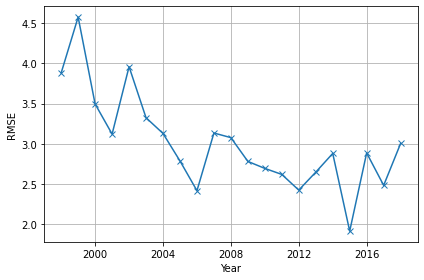

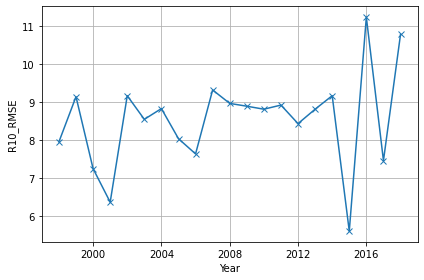

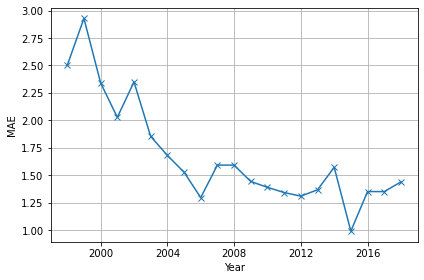

In [58]:
fp = "./Output/TRUNET_mc_dropout_Normal_True_Car_Lon_Gla_Bir_Lan_Man_Liv_Bra_Edi_Lee_Dub_Nor_Tru_New_Ply_Ban_All_train1979_1994_1998_test1998_2019-07-02__vdrop/Predictions/_regional.dat"

temp = {"fp": fp, "stochastic":False, 'distr_name':None, "model_name":"TRU-NET CC Normal"}   
a = model_evaluation(temp, rolling_annual=True )    

# Multi Model: Correlations Evaluation

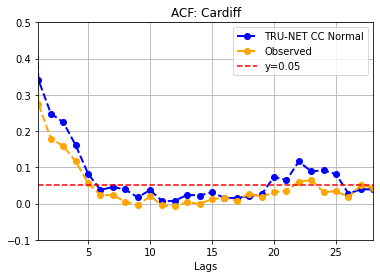

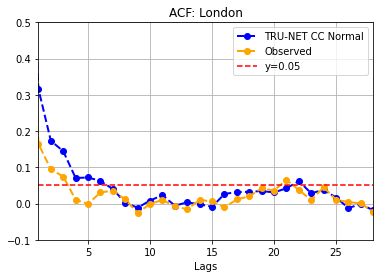

ValueError: Invalid File passed

In [78]:
#auto-correlation for point predictions for center point of cities

cities = ["Cardiff","London","Birmingham","Glasgow","Manchester"]
for city in cities:
    #temp = {"fp": f"./Output/THST_mc_dropout_Normal_True__{city}_train1979_2007_2007_2013_test2014_2019-07-02/Predictions/local.dat", "stochastic":True, 'distr_name':"Normal", "model_name":"TRU-NET CC Normal"}   
    temp = {"fp": f"./Output/TRUNET_mc_dropout_Normal_True_Car_Lon_Gla_Bir_Lan_Man_Liv_Bra_Edi_Lee_Dub_Nor_Tru_New_Ply_Ban_{city}_train1979_2009_2014_test2014_2019-07-02_/Predictions/local.dat", "stochastic":True, 'distr_name':"Normal", "model_name":"TRU-NET CC Normal"}   
    print("\n")
    
    auto_correllation_plots( temp, city, errors=False )

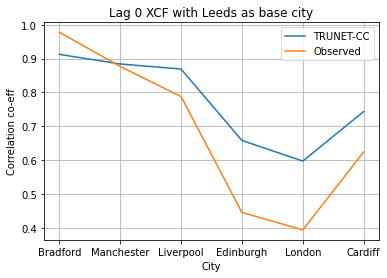

In [77]:
#cross-correlation for predictions for center point of cities

main_city_name = "Leeds"
comparison_cities = ["Bradford","Manchester","Liverpool","Edinburgh","London","Cardiff"]

#main_city = {"fp": f"./Output/THST_mc_dropout_Normal_True__{main_city_name}_train1979_2007_2007_2013_test2014_2019-07-02/Predictions/local.dat", "stochastic":True, 'distr_name':"Normal", "model_name":"TRU-NET CC Normal"}   

main_city = {"fp": f"./Output/TRUNET_mc_dropout_Normal_True_Car_Lon_Gla_Bir_Lan_Man_Liv_Bra_Edi_Lee_Dub_Nor_Tru_New_Ply_Ban_{main_city_name}_train1979_2009_2014_test2014_2019-07-02_/Predictions/local.dat", "stochastic":True, 'distr_name':"Normal", "model_name":"TRU-NET CC Normal"}

main_city = {"fp": f"./Output/TRUNET_mc_dropout_Normal_True_Car_Lon_Gla_Bir_Lan_Man_Liv_Bra_Edi_Lee_Dub_Nor_Tru_New_Ply_Ban_{main_city_name}_train1979_2009_2014_test2014_2019-07-02__vdrop/Predictions/local.dat", "stochastic":True, 'distr_name':"Normal", "model_name":"TRU-NET CC Normal"}

pd_acfl1 = pd.DataFrame(columns=comparison_cities)

for city_name in comparison_cities:
#    temp = {"fp": f"./Output/THST_mc_dropout_Normal_True__{city_name}_train1979_2007_2007_2013_test2014_2019-07-02/Predictions/local.dat", "stochastic":True, 'distr_name':"Normal", "model_name":"TRU-NET CC Normal"}   
    temp = {"fp": f"./Output/TRUNET_mc_dropout_Normal_True_Car_Lon_Gla_Bir_Lan_Man_Liv_Bra_Edi_Lee_Dub_Nor_Tru_New_Ply_Ban_{city_name}_train1979_2009_2014_test2014_2019-07-02_/Predictions/local.dat", "stochastic":True, 'distr_name':"Normal", "model_name":"TRU-NET CC Normal"}   
    #temp = {"fp": f"./Output/TRUNET_mc_dropout_Normal_True_Car_Lon_Gla_Bir_Lan_Man_Liv_Bra_Edi_Lee_Dub_Nor_Tru_New_Ply_Ban_{city_name}_train1979_2009_2014_test2014_2019-07-02__vdrop/Predictions/local.dat", "stochastic":True, 'distr_name':"Normal", "model_name":"TRU-NET CC Normal"}   
    
    print("\n")
    lag0_acf, lag0_acf_observed  = cross_correllation_plots( [main_city,temp], [main_city_name, city_name] )
    
    pd_acfl1[city_name] = [lag0_acf, lag0_acf_observed]
    
pd_acfl1.index.name ="Lag"
pd_acfl1 = pd_acfl1.set_index( pd.Index(['TRUNET-CC', 'Observed']) )
plot_lag0_xcorrs = pd_acfl1.transpose().plot.line()
plt.grid(True)
plt.xlabel('City')
plt.ylabel('Correlation co-eff')
plt.title(f'Lag 0 XCF with Leeds as base city')
_dir = "Output/Experiments/cross_corr/figures"
os.makedirs(_dir,exist_ok=True)

plt.savefig( os.path.join( _dir, f"Xcorr_lag0_{main_city_name}.png") )
plt.show()
plt.close()

# pd_acfl1.to_latex( buf=os.path.dirname(main_city['fp'])+"/x_corr_preds_table.tex",  float_format="{:0.3f}".format, caption=f"Lag 0 Cross Corellation for {main_city['model_name']} point predictions for {main_city_name} and {city_name}. \
#                         {main_city['model_name']} was trained on data \
#                "            between 1979 and 2013 and tested on the relevant $7.1 {{\\times}} 10^3$ $\mathrm{{km}}^2$ regions between 2014 and 2019-07".replace("_","\-"))

# Single Model: Decade by Decade Evaluation

In [ ]:
#decade by decade
cities = ["Cardiff","London","Birmingham","Glasgow","Manchester"]
for city in cities:
    temp = {"fp": f"./THST_mc_dropout_Normal_True__{city}_train1979_1995_1995_2000_test2000_2019-07-02/Predictions/_regional.dat", "stochastic":True, 'distr_name':"Normal", "model_name":"TRU-NET CC Normal"}    
    decade_by_decade_eval( temp, city )
    print("\n")

# Scatter Plots: Comparing Predictions to Observations

In [ ]:
#temp = {"fp": f"Output/TRUNET_mc_dropout_Normal_True_Car_Lon_Gla_Bir_Lan_Man_Liv_Bra_Edi_Lee_Dub_Nor_Tru_New_Ply_Ban_All_train1979_2009_2014_test2014_2019-07-02_/Predictions/", 'distr_name':None, "model_name":"TNET-CC"}
temp = {"fp": f"Output/ERA5/preds/All_2014_2019-06-11_pred.dat", 'distr_name':None, "model_name":"ERA5"}
scatter_plot(temp, threshold=-1)

In [ ]:
temp = {"fp": f"Output/TRUNET_mc_dropout_Normal_True_Car_Lon_Gla_Bir_Lan_Man_Liv_Bra_Edi_Lee_Dub_Nor_Tru_New_Ply_Ban_All_train1979_2009_2014_test2014_2019-07-02_/Predictions/", 'distr_name':None, "model_name":"TNET-CC"}
#temp = {"fp": f"Output/ERA5/preds/All_2014_2019-06-11_pred.dat", 'distr_name':None, "model_name":"ERA5"}
scatter_plot(temp, threshold=-1)